#<b>Milestone 1

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


## <b>Important Notes</b>

- This notebook can be considered a guide to refer to while solving the problem. The evaluation will be as per the Rubric shared for each Milestone. Unlike previous courses, it does not follow the pattern of the graded questions in different sections. This notebook would give you a direction on what steps need to be taken in order to get a viable solution to the problem. Please note that this is just one way of doing this. There can be other 'creative' ways to solve the problem and we urge you to feel free and explore them as an 'optional' exercise. 

- In the notebook, there are markdowns cells called - Observations and Insights. It is a good practice to provide observations and extract insights from the outputs.

- The naming convention for different variables can vary. Please consider the code provided in this notebook as a sample code.

- All the outputs in the notebook are just for reference and can be different if you follow a different approach.

- There are sections called **Think About It** in the notebook that will help you get a better understanding of the reasoning behind a particular technique/step. Interested learners can take alternative approaches if they want to explore different techniques. 

### Accessing AWS Sagemaker

Upon loading the AWS Sagemaker, it is important to load the packages with this command line.

In [6]:
#!pip install tensorflow

S3 bucket system is not hierarchal; the file structure is a pre-fix that you can access using the list_objects function and setting the prefix, which is similar to a filepath. When running get_execution_role, you are able to check the role permissions and add the list-bucket in-line policy if permission is not allowed with the existing role. Boto3 is the open-source code used to create, upload files, and access files off of the S3 bucket.

### <b>Loading libraries</b>

In [9]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import sagemaker
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

import boto3

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Data Loading with Boto 3</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [22]:
#File extraction was done prior to this program.

#Storing the path of the data file from the Google drive
#not sure if this path needs to be updated everytime SageMaker is run
#path = path + '/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
#with zipfile.ZipFile(path, 'r') as zip_ref:
#    zip_ref.extractall()

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

The following policy was added to the bucket:

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "Statement1",
            "Effect": "Allow",
            "Principal": {
                "AWS": <insert role based on the printed role>
            },
            "Action": "s3:*",
            "Resource": [
                "arn:aws:s3:::kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflksv2/*",
                "arn:aws:s3:::kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflksv2"
            ]
        }
    ]
}

In [12]:
#buckets created manuallly in s3 and unzippped prior to this step
bucket = 'kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflks'
train_dir = 'train' #prefix for the training directory

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
#print(role) - check role and change policy is getting access denied error

#set up the connection to s3 bucket
conn = boto3.client('s3') #limits to pulling 1,000 files, need multiple calls to API
paginator = conn.get_paginator('list_objects') #make multiple calls

#additional prefixes within the training directory
for folder_name in ['/parasitized/', '/uninfected/']:

    #initialize key list
    key_list = [ ]

    #Path of the folder
    contents = paginator.paginate(Bucket=bucket, Prefix=train_dir+folder_name).build_full_result()['Contents'] #extract list of images
    for f in contents:
        key_list.append(f['Key'])
    
    #access images from list, skip over first two keys which are "directories"
    #skipped over directories: 'unzipped/cell_images/train/', 'unzipped/cell_images/train/parasitized/'
    for i, key in enumerate(key_list):
        try:
            s3_object = conn.get_object(Bucket=bucket, Key=key)
            body = s3_object['Body']
            image = Image.open(body)
            image = image.resize((SIZE, SIZE))
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [15]:
#buckets created manuallly in s3 and unzippped prior to this step
bucket = 'kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflks'
test_dir = 'test' #prefix for the training directory

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
test_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
test_labels = []

from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
#print(role) - check role and change policy is getting access denied error

#set up the connection to s3 bucket
conn = boto3.client('s3') #limits to pulling 1,000 files, need multiple calls to API
paginator = conn.get_paginator('list_objects') #make multiple calls

#additional prefixes within the training directory
for folder_name in ['/parasitized/', '/uninfected/']:

    #initialize key list
    key_list = [ ]

    #Path of the folder
    contents = paginator.paginate(Bucket=bucket, Prefix=test_dir+folder_name).build_full_result()['Contents'] #extract list of images
    for f in contents:
        key_list.append(f['Key'])
    
    #access images from list, skip over first two keys which are "directories"
    #skipped over directories: 'unzipped/cell_images/train/', 'unzipped/cell_images/train/parasitized/'
    for i, key in enumerate(key_list):
        try:
            s3_object = conn.get_object(Bucket=bucket, Key=key)
            body = s3_object['Body']
            image = Image.open(body)
            image = image.resize((SIZE, SIZE))
            test_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b> Checking the shape of train and test images

In [16]:
print(train_images.shape)
print(test_images.shape)

(24958, 64, 64, 3)
(2600, 64, 64, 3)


###<b> Checking the shape of train and test labels

In [17]:
print(train_labels.shape)
print(test_labels.shape)

(24958,)
(2600,)


#####<b> Observations and insights: There are nearly 25,000 labels in the training dataset and 2,600 labels in the test dataset.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [19]:
print(np.amax(train_images))
print(np.amin(train_images))
print(np.amax(train_images))
print(np.amin(train_images))

255
0
255
0


#####<b> Observations and insights: The minimum and maximum are 0 and 255 respectively for both the training and testing datasets.



###<b> Count the number of values in both uninfected and parasitized 

In [24]:
# try to use value_counts to count the values
unique, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1300, 1: 1300}
{0: 12376, 1: 12582}


###<b>Normalize the images

In [25]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

#####<b> Observations and insights: All observations is in the range between 0 and 1.

###<b> Plot to check if the data is balanced

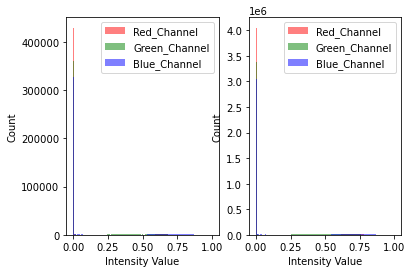

In [77]:
plt.subplot(1, 2, 1)
plt.hist(test_images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(test_images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(test_images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.subplot(1, 2, 2)
plt.hist(train_images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(train_images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(train_images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

#### Observations and insights: The distributions of the pixels in each of the red, green and blue channels are similar between the training and test dataset.

### <b>Data Exploration</b>
Let's visualize the images from the train data

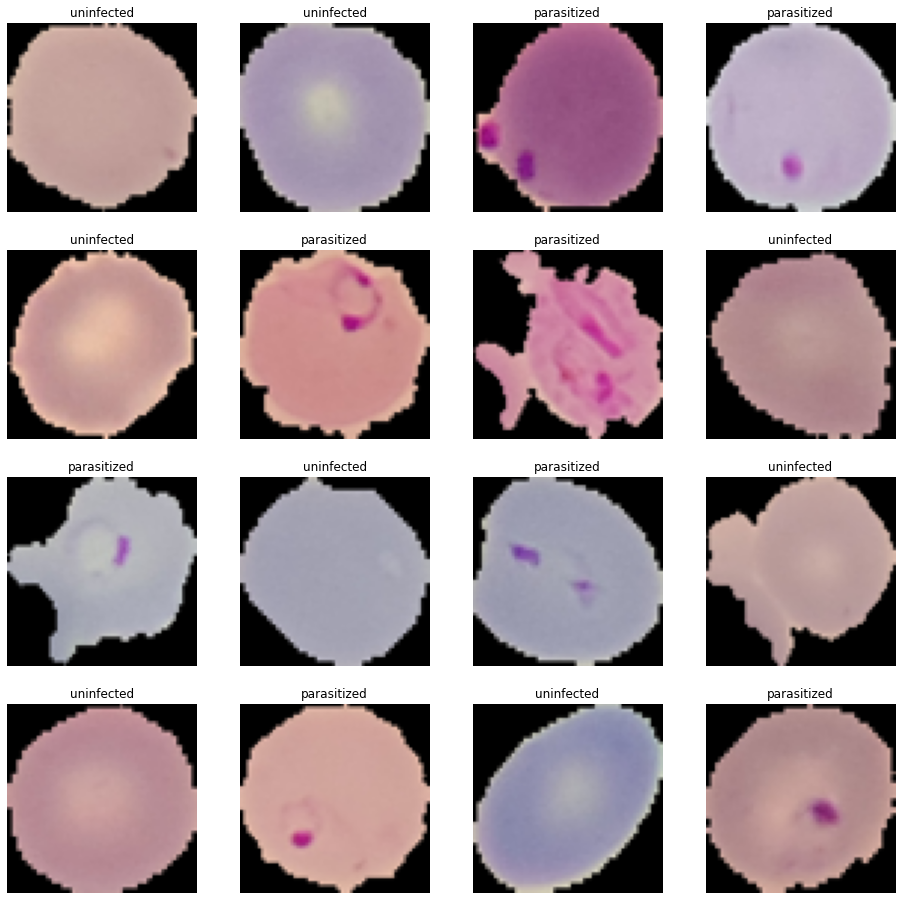

In [78]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

#####<b> Observations and insights: The parasitized cells appear to have dots on the cells, whereas the other cells do not. 

#### Similarly visualize the images with subplot(6,6) and figsize=(12,12)

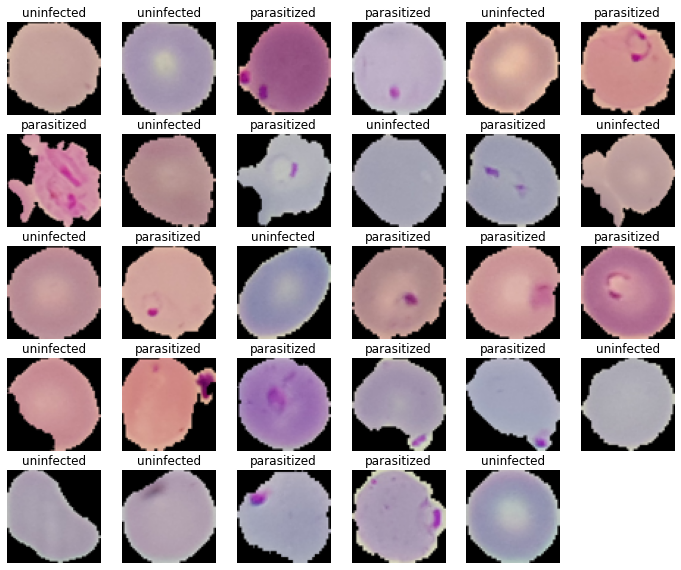

In [85]:
# Hint: Have a keen look into the number of iterations that the for loop should iterate
np.random.seed(42)
plt.figure(1 , figsize = (12 , 12))

for n in range(1, 30):
    plt.subplot(6,6, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

###### Observations and insights:  The parasitized cells are more irregular shaped than the uninfected cells; parasitized cells have more red dots.

###<b> Plotting the mean images for parasitized and uninfected

In [86]:
# function to find the mean
def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]
    # reshape it back to a matrix
    plt.imshow(mean_img)
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

<b> Mean image for parasitized

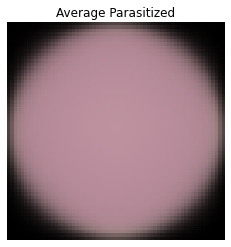

In [87]:
# If the label=1 then the image is parasitised and if the label=0 then the image is uninfected
parasitized_data=[]                                # Create a list to store the parasitized data
for img, label in zip(train_images, train_labels):
        if label==1:
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean

<b> Mean image for uninfected

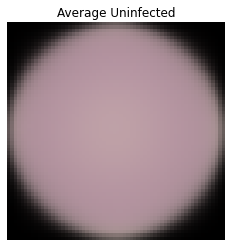

In [90]:
# If the label=1 then the image is parasitised and if the label=0 then the image is uninfected
uninfected_data=[]                                # Create a list to store the parasitized data
for img, label in zip(train_images, train_labels):
        if label==0:
              uninfected_data.append([img])          

uninfected_mean = find_mean_img(np.array(uninfected_data), 'Uninfected')   # find the mean

##### Observations and insights: The average parasitized cell is pinker than the average uninfected cell.

### <b>Converting RGB to HSV of Images using OpenCV

####<b> Converting the train data

In [91]:
import cv2
gfx=[]   # to hold the HSV image array
for i in np.arange(0,100,1):
  a=cv2.cvtColor(train_images[i],cv2.COLOR_BGR2HSV)
  gfx.append(a)
gfx=np.array(gfx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


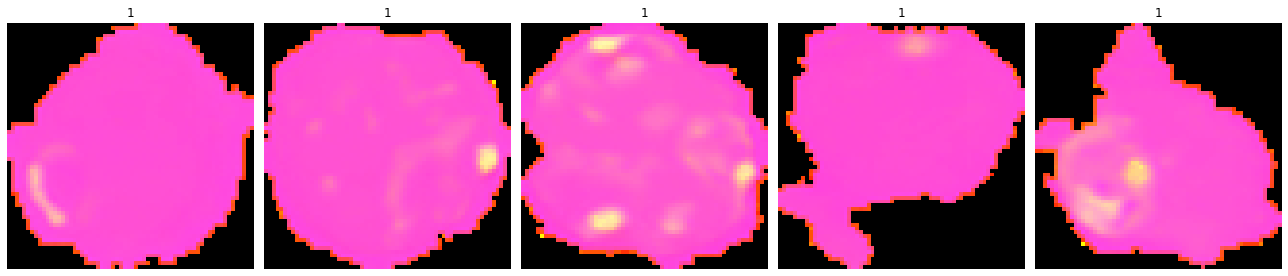

In [92]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

####<b> Converting the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


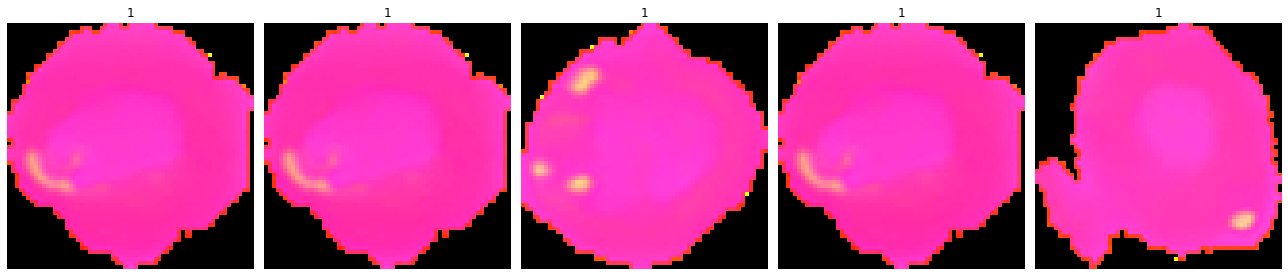

In [93]:
gfx2=[]   # to hold the HSV image array
for i in np.arange(0,100,1):
  b=cv2.cvtColor(test_images[i],cv2.COLOR_BGR2HSV)
  gfx2.append(b)
gfx2=np.array(gfx2)

viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=test_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gfx2[i])
  ax[t].set_axis_off()
  fig.tight_layout()

#####<b>Observations and insights: The infected cells have a more irregular boundary on average compared to the uninfected cells.

###<b> Processing Images using Gaussian Blurring

####<b> Gaussian Blurring on train data

In [94]:
gbx=[]  ## to hold the blurred images
for i in np.arange(0,100,1):
  b= cv2.GaussianBlur(train_images[i], (5, 5), 0)
  gbx.append(b)
gbx=np.array(gbx)

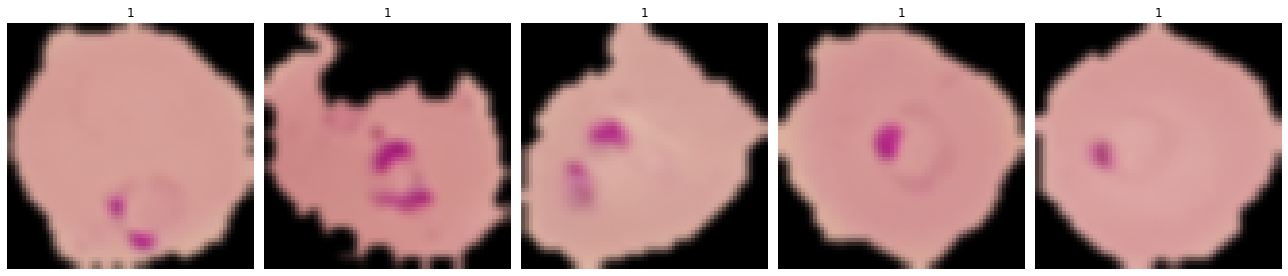

In [95]:
viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

####<b> Gaussian Blurring on test data

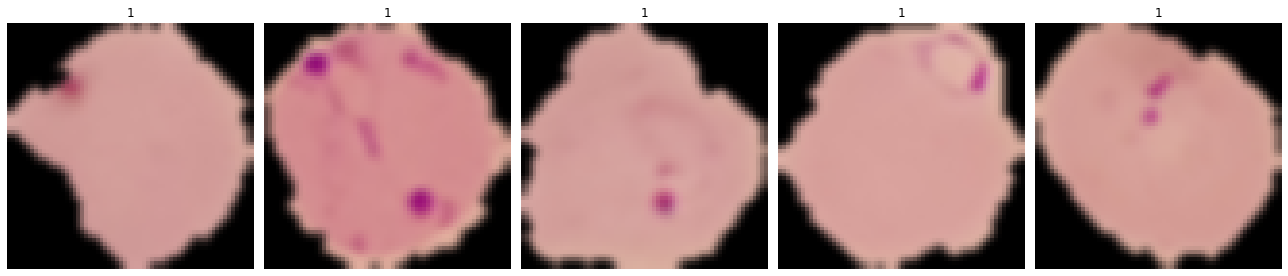

In [96]:
# Similarly you can apply Gaussian blurring for the images in the test data
gbx2=[]  ## to hold the blurred images
for i in np.arange(0,100,1):
  c= cv2.GaussianBlur(train_images[i], (5, 5), 0)
  gbx2.append(c)
gbx2=np.array(gbx2)

viewimage=np.random.randint(1,100,5)
fig,ax=plt.subplots(1,5,figsize=(18,18))
for t,i in zip(range(5),viewimage):
  Title=train_labels[i]
  ax[t].set_title(Title)
  ax[t].imshow(gbx[i])
  ax[t].set_axis_off()
  fig.tight_layout()

##### **Observations and insights:** The cells are more irregularly shaped  and the boundaries are more clear after Gaussian blurring.

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

## **Proposed approach**

**Potential techniques:** What different techniques should be explored?<br>
**Overall solution design:** What is the potential solution design?<br>
**Measures of success:** What are the key measures of success to compare different techniques?<br>